<a href="https://colab.research.google.com/github/yuzlng/Generative-model-study/blob/JAX-practice-GMM/numpy_to_jax_GaussianMixture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

In [ ]:
import time

In [ ]:
mean1 = jnp.array([0.0, 0.0])
mean2 = jnp.array([2.0, 1.0])
cov1 = jnp.array([[0.7, 0.5], [0.5, 0.7]])
cov2 = jnp.array([[0.1, -0.05], [-0.05, 0.1]])

In [ ]:
# Random key
key = jax.random.PRNGKey(123)
key1, key2 = jax.random.split(key)

data1 = jax.random.multivariate_normal(key1, mean1, cov1, shape=(1000,))
data2 = jax.random.multivariate_normal(key2, mean2, cov2, shape=(500,))

# print("Data1 shape:", data1.shape)
# print("Data2 shape:", data2.shape)


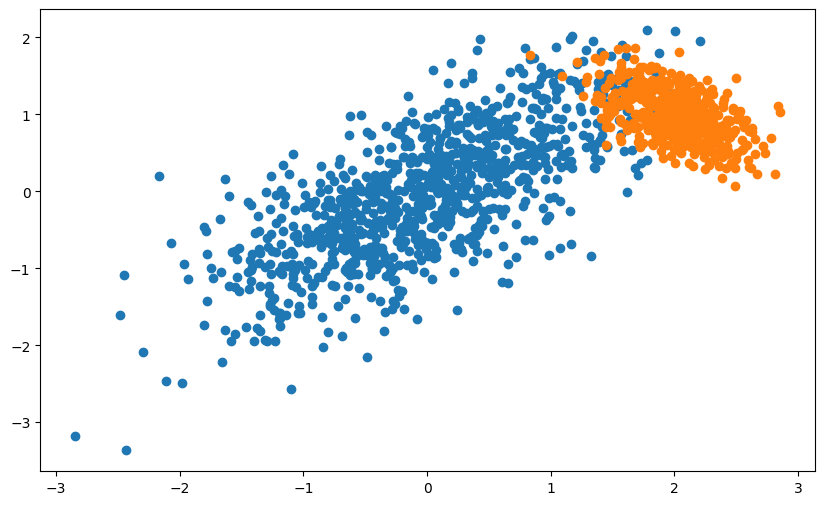

In [ ]:
def plot_scatter(data_list):
    plt.figure(figsize=(10, 6))
    for data in data_list:
        plt.scatter(data[:,0], data[:,1])
    plt.show()

plot_scatter([data1, data2])

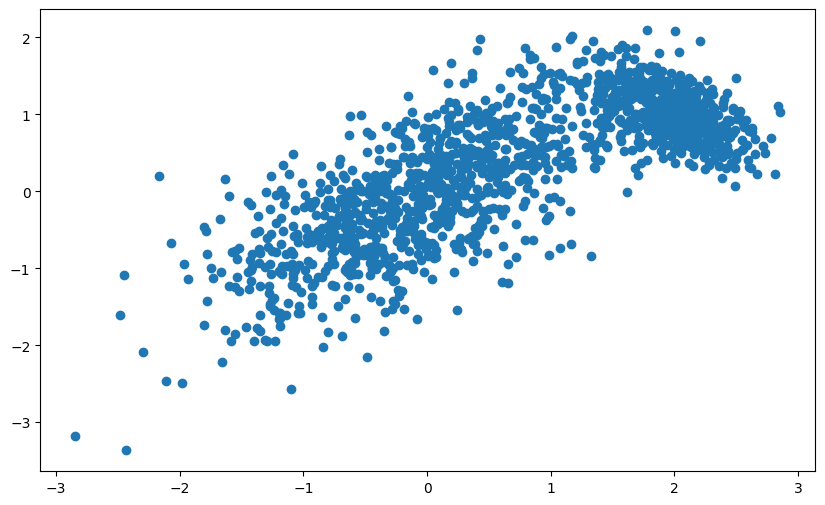

In [ ]:
X = jnp.vstack((data1, data2))
plot_scatter([X])

# data1과 data2를 수직으로 결합하여 하나의 데이터셋 X로 만듦.
# X의 크기는 (1500, 2)

In [ ]:
# import numba
# @numba.jit(parallel=True)
def compute_component_pdf(x, mus, sigmas):
    """
    mus: K x d array
    sigmas: K x d x d array
    """
    def compute_gaussian_pdf(x, mu, sigma):
        """
        x: d array
        mu: d array
        sigma: d x d array
        """
        d = len(x)
        pdf = (((jnp.pi)**d) * jnp.linalg.det(sigma))**(-0.5) * jnp.exp(-0.5 * (x - mu) @ jnp.linalg.solve(sigma, (x - mu).T))
        return pdf

    num_component = len(mus)
    return jnp.array([compute_gaussian_pdf(x, mus[k, :], sigmas[k, :, :]) for k in range(num_component)])

In [ ]:
def compute_log_likelihood_function(X, weights, mus, sigmas):
    weights = weights.reshape(-1, 1) # (K, 1)
    compute_component_prob = lambda x: compute_component_pdf(x, mus, sigmas)
    prob_nk = jnp.apply_along_axis(arr=X, func1d=compute_component_prob, axis=1) # (N, K)
    prob_component = prob_nk * weights.T # (N, K)
    likelihood = jnp.sum(prob_component, axis=1) # (N, 1)
    return likelihood, prob_component, jnp.sum(jnp.log(likelihood))

In [ ]:
def compute_responsibility(likelihood, prob_component): #gamma_nk 계산
    return prob_component / likelihood # (N, K)

In [ ]:
def compute_weights(N, N_k):
    """compute (pi_1,...,pi_K): K-dim vector"""
    return N_k / N # (1, K)

def compute_mus(X, gamma, N_k): # mu_k계산
    """compute (mu_1,...,mu_K): (K, d) matrix"""
    return (gamma.T @ X) / N_k # (K, N) x (N, d) = (K, d)

def compute_covariance(X, gamma, mus, N_k):
    """compute (sigma_1,...,sigma_K): (K, d, d) tensor"""
    centered_X = (X[jnp.newaxis, :, :] - mus[:, jnp.newaxis, :])[:, :, :, jnp.newaxis] # (K, N, d, 1)
    cov_matrix = centered_X @ centered_X.transpose(0, 1, 3, 2) # (K, N, d, d)
    (gamma.T)[:, :, jnp.newaxis, jnp.newaxis] * cov_matrix # (K, N, d, d)
    return jnp.sum(cov_matrix, axis=1) / N_k # (K, d, d)

In [ ]:
class GaussianMixture():
    def __init__(self, num_components=2, key=jax.random.PRNGKey(42)): # Pass a PRNG key during initialization
        self.num_components = num_components
        self.weights = None
        self.mus = None
        self.sigmas = None
        self.log_likelihood = None
        self.gamma = None
        self.X = None
        self.N = None
        self.key = key # Store the key as an attribute

    def init_parameters(self):
        self.weights = jnp.ones(self.num_components) / self.num_components
        self.key, subkey = jax.random.split(self.key)
        indices = jax.random.choice(subkey, self.N, shape=(self.num_components,), replace=False)
        self.mus = self.X[indices]
        self.sigmas = jnp.array([jnp.cov(self.X.T) for _ in range(self.num_components)])

    def compute_log_likelihood_function(self):
        weights = self.weights.reshape(-1, 1) # (K, 1)
        compute_component_prob = lambda x: compute_component_pdf(x, self.mus, self.sigmas)

        # prob_nk = np.apply_along_axis(arr=self.X, func1d=compute_component_prob, axis=1)
        prob_nk = jax.vmap(compute_component_prob)(self.X)  # (N, K)

        prob_component = prob_nk * weights.T # (N, K)
        likelihood = jnp.sum(prob_component, axis=1, keepdims=True) # (N, 1)
        self.log_likelihood = jnp.sum(jnp.log(likelihood)) / self.N # update log_likelihood
        return likelihood, prob_component

    def compute_responsibility(self, likelihood, prob_component):
        return prob_component / likelihood # (N, K)

    def compute_weights(self, N_k):
        """compute (pi_1,...,pi_K): K-dim vector"""
        return N_k / self.N # (1, K)

    def compute_mus(self, N_k):
        """compute (mu_1,...,mu_K): (K, d) matrix"""
        N_k = N_k.reshape(-1, 1) # (K, 1)
        return (self.gamma.T @ self.X) / N_k # (K, N) x (N, d) = (K, d)

    def compute_covariance(self, N_k):
        """compute (sigma_1,...,sigma_K): (K, d, d) tensor"""
        N_k = N_k.reshape(-1, 1, 1)  # (K, 1, 1)
        centered_X = (self.X[jnp.newaxis, :, :] - self.mus[:, jnp.newaxis, :])[:, :, :, jnp.newaxis]  # (K, N, d, 1)
        cov_matrix = centered_X @ centered_X.transpose(0, 1, 3, 2)  # (K, N, d, d)
        cov_matrix = (self.gamma.T)[:, :, jnp.newaxis, jnp.newaxis] * cov_matrix  # (K, N, d, d)
        return jnp.sum(cov_matrix, axis=1) / N_k  # (K, d, d)


    def E_step(self):
        # parameter initialization
        if self.weights is None:
            self.init_parameters()
        likelihood, prob_component = self.compute_log_likelihood_function()
        self.gamma = self.compute_responsibility(likelihood, prob_component)

    def M_step(self):
        if self.weights is None:
            self.E_step()
        N_k = jnp.sum(self.gamma, axis=0) # (K, )
        self.weights = self.compute_weights(N_k)
        self.mus = self.compute_mus(N_k)
        self.sigmas = self.compute_covariance(N_k)

    def fit(self, X, max_iter=100, tol=1e-4):
        self.X = X
        self.N = len(self.X)
        self.init_parameters()
        prev_log_likelihood = -jnp.inf

        start_time = time.time()
        # iterative update
        for iter in range(max_iter):
            self.E_step()

            if self.log_likelihood - prev_log_likelihood < tol:
                break
            else:
                prev_log_likelihood = self.log_likelihood
                self.M_step()

        end_time = time.time()
        wall_clock_time = end_time - start_time
        print(f"EM algorithm is done at {iter}-th step. (wall-clock time: {wall_clock_time} secs)\nLog-likelihood: {self.log_likelihood}")
        print("="*30)
        print(f"- Estimated mixture weights:\n{self.weights}")
        print("-"*20)
        print(f"- Estimated mus:\n{self.mus}")
        print("-"*20)
        print(f"- Estimated sigmas:\n{self.sigmas}")
        print("="*30)

    def sampling(self, sample_size=1000):
        key1, key2 = jax.random.split(self.key)  # 키 분할
        index_set = jnp.arange(self.num_components)
        index = jax.random.choice(key1, index_set, p=self.weights, shape=(sample_size,))

        # 각 성분에 대해 샘플 생성
        sampled_data = [
            jax.random.multivariate_normal(key2, self.mus[k, :], self.sigmas[k, :, :], shape=(sample_size,))[index == k]
            for k in index_set
        ]
        return sampled_data

In [ ]:
gmm = GaussianMixture(num_components=2)

In [ ]:
gmm.fit(X, max_iter=100)
data = gmm.sampling()

EM algorithm is done at 24-th step. (wall-clock time: 1.3319809436798096 secs)
Log-likelihood: -1.396665334701538
- Estimated mixture weights:
[0.34759966 0.6524004 ]
--------------------
- Estimated mus:
[[ 1.9834086   1.008518  ]
 [-0.04820413 -0.06126676]]
--------------------
- Estimated sigmas:
[[[ 0.10267737 -0.05370996]
  [-0.05370996  0.10818678]]

 [[ 0.658768    0.47136807]
  [ 0.47136807  0.68283486]]]


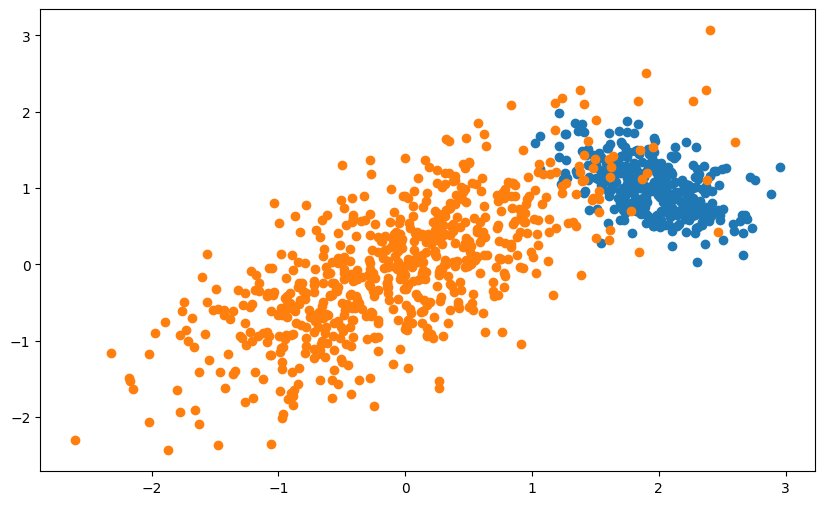

In [ ]:
plot_scatter(data)



---



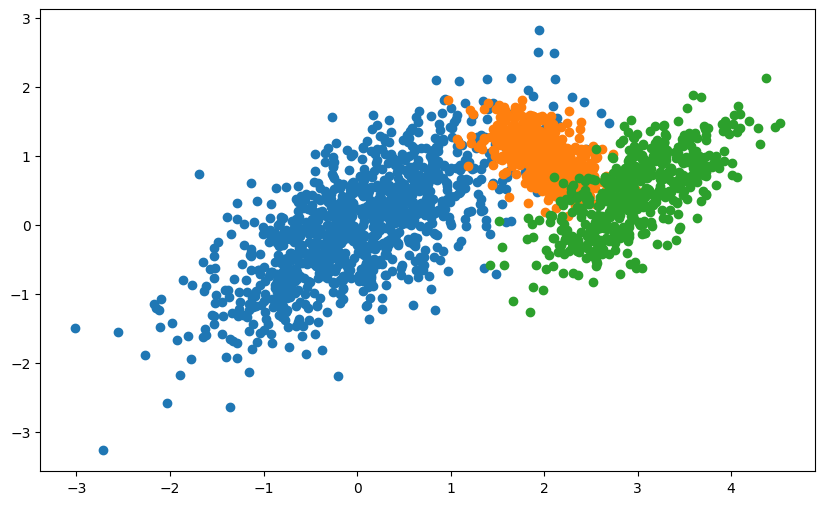

In [ ]:
mean1 = jnp.array([0.0, 0.0])
mean2 = jnp.array([2.0, 1.0])
mean3 = jnp.array([3.0, 0.5])
cov1 = jnp.array([[0.7, 0.5], [0.5, 0.7]])
cov2 = jnp.array([[0.1, -0.05], [-0.05, 0.1]])
cov3 = jnp.array([[0.3, 0.2], [0.2, 0.3]])

key = jax.random.PRNGKey(123)
key, subkey1, subkey2, subkey3 = jax.random.split(key, 4)

data1 = jax.random.multivariate_normal(subkey1, mean1, cov1, shape=(1000,))
data2 = jax.random.multivariate_normal(subkey2, mean2, cov2, shape=(500,))
data3 = jax.random.multivariate_normal(subkey3, mean3, cov3, shape=(500,))
plot_scatter([data1, data2, data3])


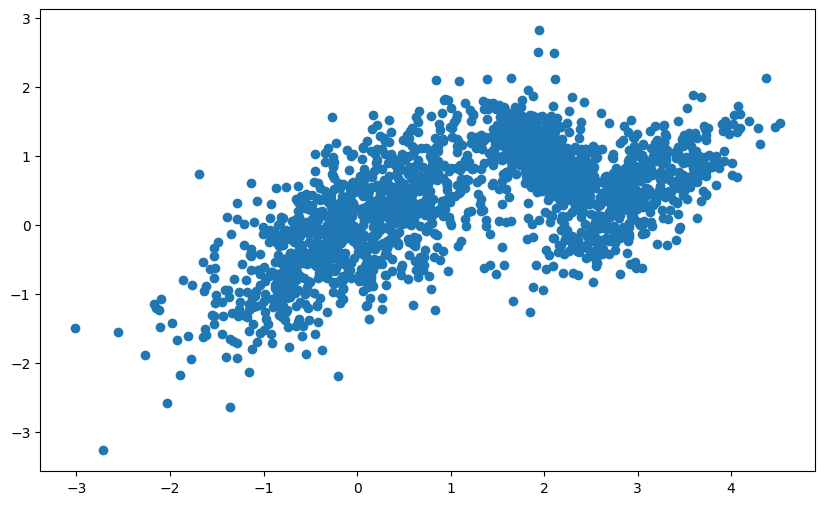

In [ ]:
X = jnp.vstack((data1, data2, data3))
plot_scatter([X])

In [ ]:
gmm = GaussianMixture(num_components=3)

In [ ]:
gmm.fit(X, max_iter=1000)
sampled_data = gmm.sampling(sample_size=2000)

EM algorithm is done at 26-th step. (wall-clock time: 0.5172419548034668 secs)
Log-likelihood: -1.709726333618164
- Estimated mixture weights:
[0.50329053 0.2495616  0.2471479 ]
--------------------
- Estimated mus:
[[0.04031188 0.01528764]
 [2.9756358  0.47554258]
 [2.0043356  1.0048268 ]]
--------------------
- Estimated sigmas:
[[[ 0.68039083  0.47837892]
  [ 0.47837892  0.6760256 ]]

 [[ 0.28410447  0.20371145]
  [ 0.20371145  0.31743988]]

 [[ 0.1045393  -0.05879249]
  [-0.05879249  0.10768754]]]


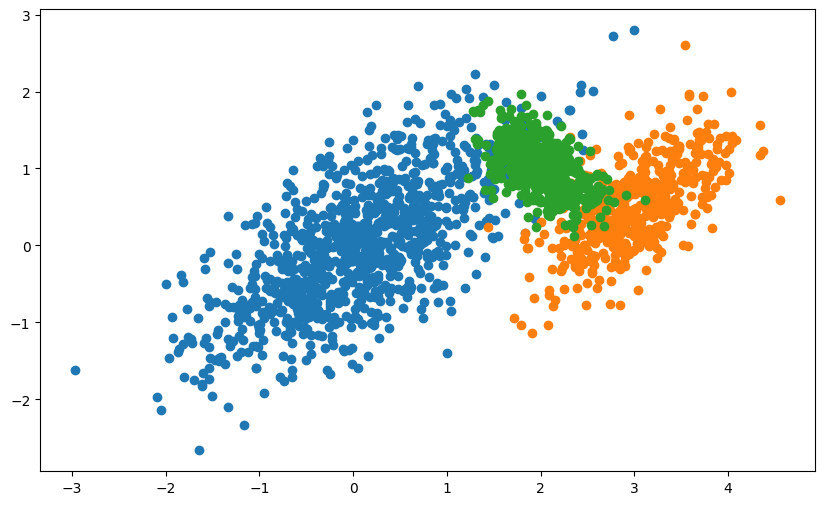

In [ ]:
plot_scatter(sampled_data)



---



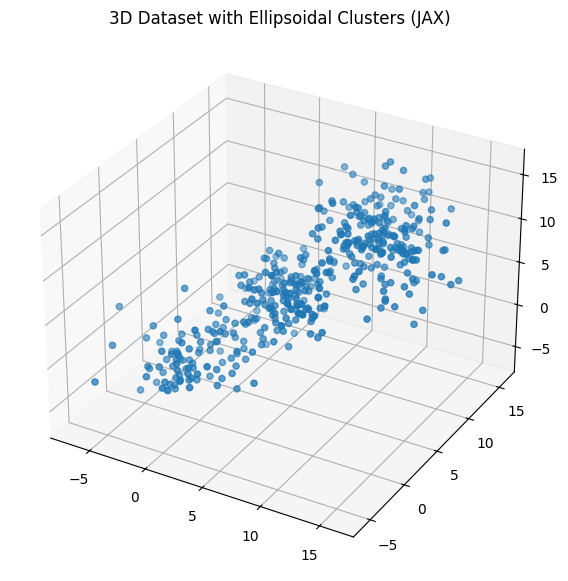

In [ ]:
means = jnp.array([[0, 0, 0], [5, 5, 5], [10, 10, 10]])
covs = [jnp.eye(3), jnp.eye(3) * 2, jnp.eye(3) / 2]  # Different covariances for variety
sizes = [100, 150, 200]  # Different sizes for the clusters
covs_very_spreaded = [
    jnp.array([[5, 2, 1], [2, 5, 2], [1, 2, 5]]),
    jnp.array([[5, -2, 1], [-2, 5, -1], [1, -1, 5]]),
    jnp.array([[5, 0, -2], [0, 5, 2], [-2, 2, 5]])
]

# Generate data using JAX
key = jax.random.PRNGKey(123)
keys = jax.random.split(key, len(sizes))
real_data = jnp.vstack([
    jax.random.multivariate_normal(k, mean, cov, shape=(size,))
    for k, mean, cov, size in zip(keys, means, covs_very_spreaded, sizes)
])

# Plotting the generated very spreaded ellipsoidal clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(real_data[:, 0], real_data[:, 1], real_data[:, 2])
ax.set_title('3D Dataset with Ellipsoidal Clusters (JAX)')
plt.show()


In [ ]:
gmm_3d = GaussianMixture(num_components=3)
gmm_3d.fit(real_data, max_iter=1000)
sampled_data_3d = gmm_3d.sampling(sample_size=2000)

EM algorithm is done at 113-th step. (wall-clock time: 5.302300691604614 secs)
Log-likelihood: -6.493484020233154
- Estimated mixture weights:
[0.41516784 0.47523695 0.10959525]
--------------------
- Estimated mus:
[[ 9.948527  10.052506  10.044302 ]
 [ 3.0030053  2.163872   2.902743 ]
 [ 3.4817145  7.517656   4.5359616]]
--------------------
- Estimated sigmas:
[[[ 5.436983    0.07958567 -2.3426628 ]
  [ 0.07958567  4.63164     1.9237592 ]
  [-2.3426628   1.9237592   4.9700904 ]]

 [[14.210274    7.870302   10.55209   ]
  [ 7.870302    9.276872    7.6028137 ]
  [10.55209     7.6028137  13.777241  ]]

 [[ 3.7642334   0.07381936  1.9225016 ]
  [ 0.07381936  2.031258   -0.6358087 ]
  [ 1.9225016  -0.6358087   4.456465  ]]]


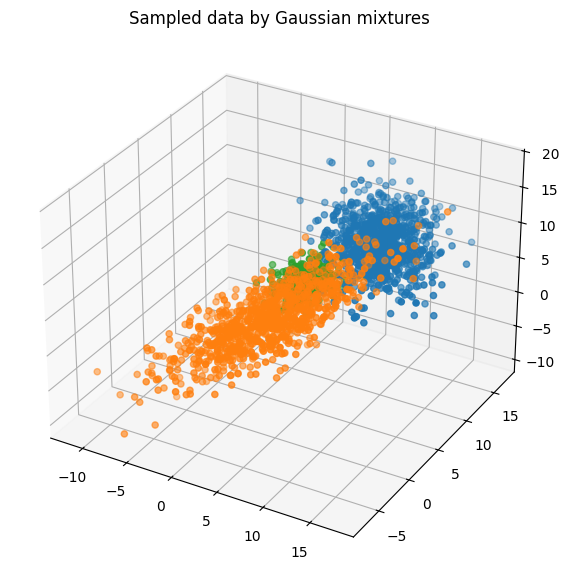

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for i in range(3):
    ax.scatter(sampled_data_3d[i][:, 0], sampled_data_3d[i][:, 1], sampled_data_3d[i][:, 2])
ax.set_title('Sampled data by Gaussian mixtures')
plt.show()

In [ ]:
import pandas as pd

# https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data
!kaggle datasets download -d parulpandey/palmer-archipelago-antarctica-penguin-data
!unzip palmer-archipelago-antarctica-penguin-data

# load the dataset
df = pd.read_csv('penguins_size.csv')

# remove null values
df = df[~df.isnull().any(axis=1)]
df = df.reset_index(drop=True)
features = ['culmen_length_mm', 'culmen_depth_mm']
data = df[features]
data_ndarray = jnp.array(data)

Dataset URL: https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data
License(s): CC0-1.0
  0% 0.00/11.3k [00:00<?, ?B/s]
100% 11.3k/11.3k [00:00<00:00, 19.7MB/s]
Archive:  palmer-archipelago-antarctica-penguin-data.zip
  inflating: penguins_lter.csv       
  inflating: penguins_size.csv       


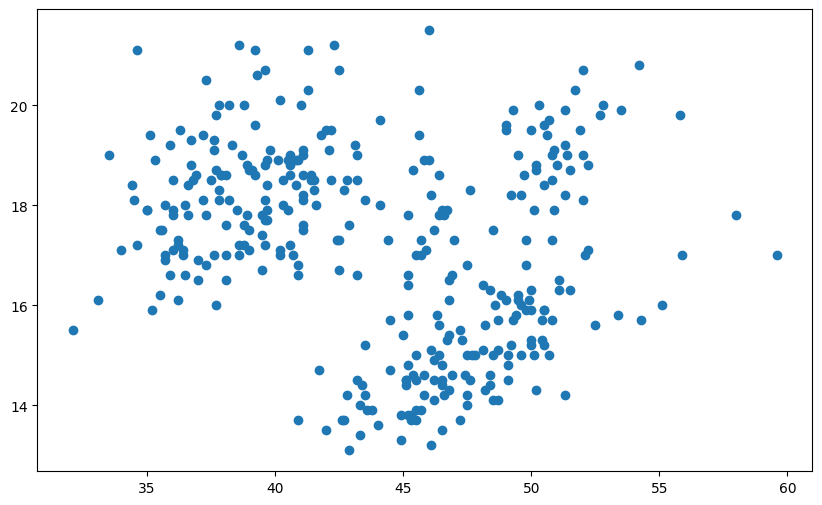

In [ ]:
plot_scatter([data_ndarray])

EM algorithm is done at 79-th step. (wall-clock time: 1.718003749847412 secs)
Log-likelihood: -4.111053943634033
- Estimated mixture weights:
[0.32458395 0.4248208  0.2505953 ]
--------------------
- Estimated mus:
[[47.304657 14.853544]
 [38.692783 18.295393]
 [48.69394  18.224554]]
--------------------
- Estimated sigmas:
[[[ 7.927351    1.6564044 ]
  [ 1.6564044   0.77446896]]

 [[ 6.421795    0.9806206 ]
  [ 0.9806206   1.4679867 ]]

 [[13.548464    1.5078771 ]
  [ 1.5078771   1.7067871 ]]]


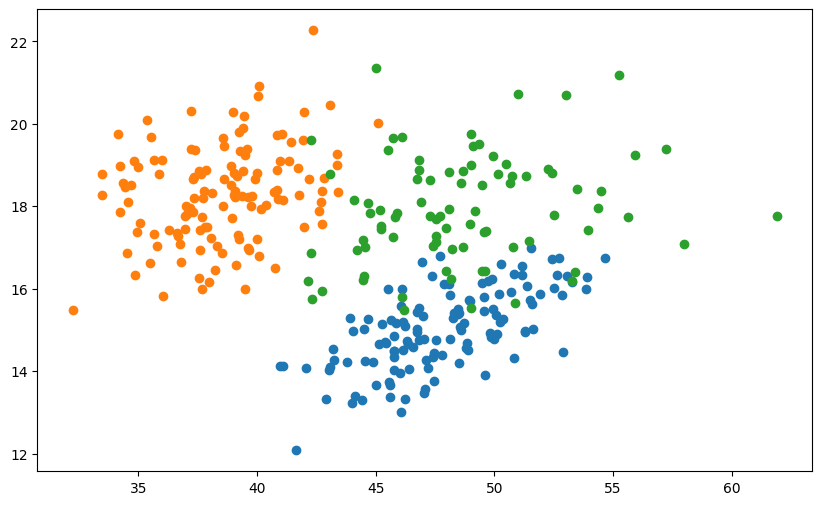

In [ ]:
gmm_penguin = GaussianMixture(num_components=3)
gmm_penguin.fit(data_ndarray, max_iter=1000)
sampled_data_penguin = gmm_penguin.sampling(sample_size=len(data_ndarray))
plot_scatter(sampled_data_penguin)